In [38]:
# %load ../src/goes16_utils.py
# Training: Python and GOES-R Imagery: Script 8 - Functions for download data from AWS
#-----------------------------------------------------------------------------------------------------------
# Required modules
import os                                # Miscellaneous operating system interfaces
import numpy as np                       # Import the Numpy package
import colorsys                          # To make convertion of colormaps
import boto3                             # Amazon Web Services (AWS) SDK for Python
from botocore import UNSIGNED            # boto3 config
from botocore.config import Config       # boto3 config
import math                              # Mathematical functions
from datetime import datetime            # Basic Dates and time types
from osgeo import osr                    # Python bindings for GDAL
from osgeo import gdal                   # Python bindings for GDAL

#-----------------------------------------------------------------------------------------------------------
def loadCPT(path):

    try:
        f = open(path)
    except:
        print ("File ", path, "not found")
        return None

    lines = f.readlines()

    f.close()

    x = np.array([])
    r = np.array([])
    g = np.array([])
    b = np.array([])

    colorModel = 'RGB'

    for l in lines:
        ls = l.split()
        if l[0] == '#':
            if ls[-1] == 'HSV':
                colorModel = 'HSV'
                continue
            else:
                continue
        if ls[0] == 'B' or ls[0] == 'F' or ls[0] == 'N':
            pass
        else:
            x=np.append(x,float(ls[0]))
            r=np.append(r,float(ls[1]))
            g=np.append(g,float(ls[2]))
            b=np.append(b,float(ls[3]))
            xtemp = float(ls[4])
            rtemp = float(ls[5])
            gtemp = float(ls[6])
            btemp = float(ls[7])

        x=np.append(x,xtemp)
        r=np.append(r,rtemp)
        g=np.append(g,gtemp)
        b=np.append(b,btemp)

    if colorModel == 'HSV':
        for i in range(r.shape[0]):
            rr, gg, bb = colorsys.hsv_to_rgb(r[i]/360.,g[i],b[i])
        r[i] = rr ; g[i] = gg ; b[i] = bb

    if colorModel == 'RGB':
        r = r/255.0
        g = g/255.0
        b = b/255.0

    xNorm = (x - x[0])/(x[-1] - x[0])

    red   = []
    blue  = []
    green = []

    for i in range(len(x)):
        red.append([xNorm[i],r[i],r[i]])
        green.append([xNorm[i],g[i],g[i]])
        blue.append([xNorm[i],b[i],b[i]])

    colorDict = {'red': red, 'green': green, 'blue': blue}

    return colorDict
#-----------------------------------------------------------------------------------------------------------
def download_CMI(yyyymmddhhmn, band, path_dest):

  os.makedirs(path_dest, exist_ok=True)

  year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%Y')
  day_of_year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%j')
  hour = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%H')
  min = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%M')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'
  product_name = 'ABI-L2-CMIPF'

  # Initializes the S3 client
  s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
  #-----------------------------------------------------------------------------------------------------------
  # File structure
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}-M6C{int(band):02.0f}_G16_s{year}{day_of_year}{hour}{min}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmn}, Band-{band}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

#-----------------------------------------------------------------------------------------------------------
def download_PROD(yyyymmddhhmn, product_name, path_dest):

  # os.makedirs(path_dest, exist_ok=True)

  year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%Y')
  day_of_year = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%j')
  hour = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%H')
  min = datetime.strptime(yyyymmddhhmn, '%Y%m%d%H%M').strftime('%M')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'

  # Initializes the S3 client
  # s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

  #-----------------------------------------------------------------------------------------------------------
  # File structure
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}-M6_G16_s{year}{day_of_year}{hour}{min}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmn}, Product: {product_name}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # print(f'File name: {file_name}')

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        # print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

#-----------------------------------------------------------------------------------------------------------
def download_GLM(yyyymmddhhmnss, path_dest):

  os.makedirs(path_dest, exist_ok=True)

  year = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%Y')
  day_of_year = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%j')
  hour = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%H')
  min = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%M')
  seg = datetime.strptime(yyyymmddhhmnss, '%Y%m%d%H%M%S').strftime('%S')

  # AMAZON repository information
  # https://noaa-goes16.s3.amazonaws.com/index.html
  bucket_name = 'noaa-goes16'

  # Initializes the S3 client
  s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
  #-----------------------------------------------------------------------------------------------------------
  # File structure
  product_name = "GLM-L2-LCFA"
  prefix = f'{product_name}/{year}/{day_of_year}/{hour}/OR_{product_name}_G16_s{year}{day_of_year}{hour}{min}{seg}'

  # Seach for the file on the server
  s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")

  #-----------------------------------------------------------------------------------------------------------
  # Check if there are files available
  if 'Contents' not in s3_result:
    # There are no files
    print(f'No files found for the date: {yyyymmddhhmnss}, Product-{product_name}')
    return -1
  else:
    # There are files
    for obj in s3_result['Contents']:
      key = obj['Key']
      # Print the file name
      file_name = key.split('/')[-1].split('.')[0]

      # Download the file
      if os.path.exists(f'{path_dest}/{file_name}.nc'):
        print(f'File {path_dest}/{file_name}.nc exists')
      else:
        print(f'Downloading file {path_dest}/{file_name}.nc')
        s3_client.download_file(bucket_name, key, f'{path_dest}/{file_name}.nc')
  return f'{file_name}'

#-----------------------------------------------------------------------------------------------------------
# Functions to convert lat / lon extent to array indices
def geo2grid(lat, lon, nc):

    # Apply scale and offset
    xscale, xoffset = nc.variables['x'].scale_factor, nc.variables['x'].add_offset
    yscale, yoffset = nc.variables['y'].scale_factor, nc.variables['y'].add_offset

    x, y = latlon2xy(lat, lon)
    col = (x - xoffset)/xscale
    lin = (y - yoffset)/yscale
    return int(lin), int(col)

def latlon2xy(lat, lon):
    # goes_imagery_projection:semi_major_axis
    req = 6378137 # meters
    #  goes_imagery_projection:inverse_flattening
    invf = 298.257222096
    # goes_imagery_projection:semi_minor_axis
    rpol = 6356752.31414 # meters
    e = 0.0818191910435
    # goes_imagery_projection:perspective_point_height + goes_imagery_projection:semi_major_axis
    H = 42164160 # meters
    # goes_imagery_projection: longitude_of_projection_origin
    lambda0 = -1.308996939

    # Convert to radians
    latRad = lat * (math.pi/180)
    lonRad = lon * (math.pi/180)

    # (1) geocentric latitude
    Phi_c = math.atan(((rpol * rpol)/(req * req)) * math.tan(latRad))
    # (2) geocentric distance to the point on the ellipsoid
    rc = rpol/(math.sqrt(1 - ((e * e) * (math.cos(Phi_c) * math.cos(Phi_c)))))
    # (3) sx
    sx = H - (rc * math.cos(Phi_c) * math.cos(lonRad - lambda0))
    # (4) sy
    sy = -rc * math.cos(Phi_c) * math.sin(lonRad - lambda0)
    # (5)
    sz = rc * math.sin(Phi_c)

    # x,y
    x = math.asin((-sy)/math.sqrt((sx*sx) + (sy*sy) + (sz*sz)))
    y = math.atan(sz/sx)

    return x, y

# Function to convert lat / lon extent to GOES-16 extents
def convertExtent2GOESProjection(extent):
    # GOES-16 viewing point (satellite position) height above the earth
    GOES16_HEIGHT = 35786023.0
    # GOES-16 longitude position
    GOES16_LONGITUDE = -75.0

    a, b = latlon2xy(extent[1], extent[0])
    c, d = latlon2xy(extent[3], extent[2])
    return (a * GOES16_HEIGHT, c * GOES16_HEIGHT, b * GOES16_HEIGHT, d * GOES16_HEIGHT)

#-----------------------------------------------------------------------------------------------------------
# Function to reproject the data
def reproject(file_name, ncfile, array, extent, undef):

    # Read the original file projection and configure the output projection
    source_prj = osr.SpatialReference()
    source_prj.ImportFromProj4(ncfile.GetProjectionRef())

    target_prj = osr.SpatialReference()
    target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    # Reproject the data
    GeoT = ncfile.GetGeoTransform()
    driver = gdal.GetDriverByName('MEM')
    raw = driver.Create('raw', array.shape[0], array.shape[1], 1, gdal.GDT_Float32)
    raw.SetGeoTransform(GeoT)
    raw.GetRasterBand(1).WriteArray(array)

    # Define the parameters of the output file
    kwargs = {'format': 'netCDF', \
            'srcSRS': source_prj, \
            'dstSRS': target_prj, \
            'outputBounds': (extent[0], extent[3], extent[2], extent[1]), \
            'outputBoundsSRS': target_prj, \
            'outputType': gdal.GDT_Float32, \
            'srcNodata': undef, \
            'dstNodata': 'nan', \
            'resampleAlg': gdal.GRA_NearestNeighbour}

    # Write the reprojected file on disk
    gdal.Warp(file_name, raw, **kwargs)

In [39]:
path = '../data/goes16/'
file_name = 'OR_ABI-L2-DSIF-M6_G16_s20220911700205_e20220911709513_c20220911711480.nc'

In [42]:
# Python and GOES-R Imagery Exampe: Cropping the DSIF imagery 
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset              # Read / Write NetCDF4 files
import matplotlib.pyplot as plt          # Plotting library
from datetime import datetime            # Basic Dates and time types
import cartopy, cartopy.crs as ccrs      # Plot maps
import os                                # Miscellaneous operating system interfaces

import pickle

# Desired extent
extent = [-64.0, -36.0, -40.0, -15.0]  # Min lon, Max lon, Min lat, Max lat
#-----------------------------------------------------------------------------------------------------------
# Open the GOES-R image
file = Dataset(path+file_name)

print(file)

# Convert lat/lon to grid-coordinates
lly, llx = geo2grid(extent[1], extent[0], file)
ury, urx = geo2grid(extent[3], extent[2], file)

dict_indices = {}
for instability_index_name in ['CAPE', 'LI', 'TT', 'SI', 'KI']:
    # Get the pixel values
    data = file.variables[instability_index_name][ury:lly, llx:urx]
    dict_indices[instability_index_name] = data

data = file.variables['DQF_Overall'][ury:lly, llx:urx]
dict_indices['DQF_Overall'] = data

# open a file, where you want to store the data
temp = os.path.splitext(file_name)  # given '/home/user/somefile.nc',  returns ('/home/user/somefile', '.nc')
pkl_file = open(f'{temp[0]}.pkl', 'wb')

# dump information to that file
pickle.dump(dict_indices, pkl_file)

# close the file
pkl_file.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 10km at nadir
    orbital_slot: GOES-East
    platform_ID: G16
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: Full Disk
    instrument_ID: FM1
    dataset_name: OR_ABI-L2-DSIF-M6_G16_s20220911700205_e20220911709513_c20220911711480.nc
    iso_series_metadata_id: 158fae30-affd-11e1-afa6-0800200c9a66
    title: ABI L2 Derived Stability Indices
    summary: The Derived Stability Indices product consists of the atmosphe

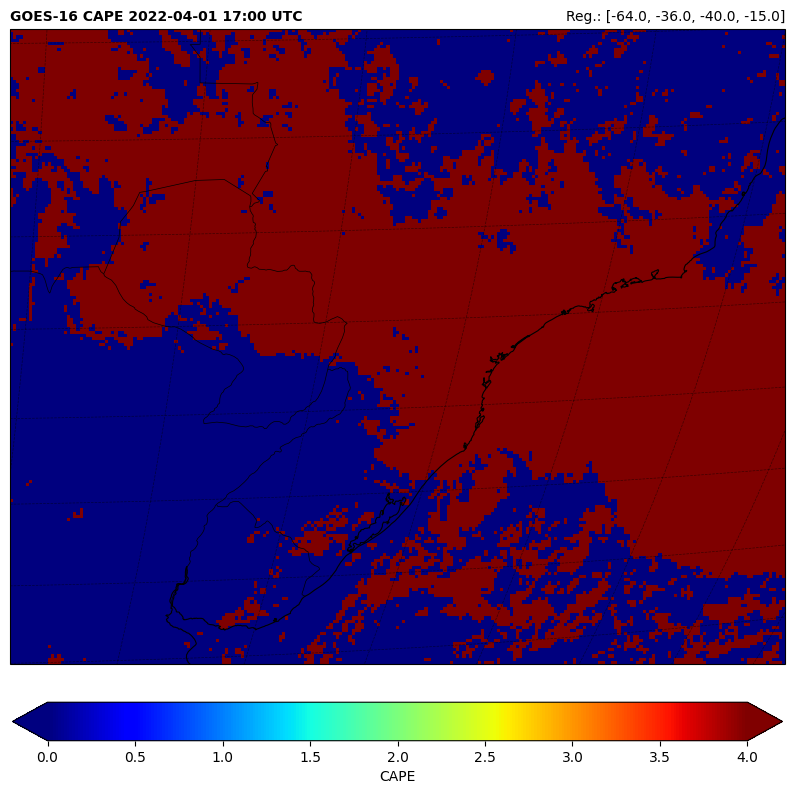

In [43]:
#-----------------------------------------------------------------------------------------------------------
# Compute data-extent in GOES projection-coordinates
img_extent = convertExtent2GOESProjection(extent)
#-----------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(10,10))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))

# Define the color scale based on the channel
colormap = "jet" # White to black for IR channels
        
# Plot the image
img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='black', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.5)

# Add a colorbar
plt.colorbar(img, label='CAPE', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# Extract the date
date = (datetime.strptime(file.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 CAPE ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'OR_ABI-L2-DSIF-M6_G16_s20210632010164_e20210632019472_c20210632020547.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()